In [426]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from catboost import CatBoostClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE

### Load Data

In [336]:
df = pd.read_csv("mod_data.csv")
df.head()

,Ticker,Nama Perusahaan,Tanggal Listing,Sektor,Underwriter,Papan Pencatatan,Ownership,Listed Share,Persen Saham Ditawarkan,Rencana Penggunaan Dana IPO,...,Total Liabilitas,Pendapatan,Laba Kotor,Laba Berjalan (Bukan Komperhensif),Harga Final,1D %,1W %,1M %,6M %,1Y %
0,UNIQ,PT Ulima Nitra Tbk,8-Mar-21,Energy,PT Surya Fajar Sekuritas,utama,lainnya,3.138983e+09,0.0956,modal kerja,...,2.674160e+11,2.709260e+11,2.454700e+10,-5.617000e+09,118,999,35,5.0,-25.0,-30.0
1,GTRA,PT Grahaprima Suksesmandiri Tbk,30-Mar-23,Transportation & Logistic,PT UOB Kay Hian Sekuritas,pengembangan,lainnya,1.894375e+09,0.2000,modal belanja,...,4.565140e+11,1.953170e+11,8.756900e+10,1.129220e+11,150,999,85,77.0,39.0,9.0
2,BSBK,PT Wulandari Bangun Laksana Tbk,8-Nov-22,Properties & Real Estate,PT KGI Sekuritas Indonesia; PT Panca Global Se...,pengembangan,lainnya,2.275000e+10,0.1209,modal kerja,...,1.116300e+12,5.590600e+10,3.895000e+10,-1.943000e+09,100,999,170,140.0,-50.0,-50.0
3,COAL,PT Black Diamond Resources Tbk,7-Sep-22,Energy,PT Surya Fajar Sekuritas,pemantauan khusus,lainnya,6.250000e+09,0.2000,modal kerja,...,2.495770e+14,9.553076e+10,4.902891e+10,4.330173e+10,100,999,280,354.0,36.0,-45.0
4,CRAB,PT Toba Surimi Industries Tbk,10-Aug-22,Consumer Non-Cyclicals,PT KGI Sekuritas Indonesia,pengembangan,lainnya,1.950000e+09,0.2000,modal kerja,...,2.472970e+11,1.355930e+11,1.738746e+10,2.926422e+09,150,999,56,59.0,41.0,59.0


In [337]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Ticker                              223 non-null    object 
 1   Nama Perusahaan                     223 non-null    object 
 2   Tanggal Listing                     223 non-null    object 
 3   Sektor                              223 non-null    object 
 4   Underwriter                         223 non-null    object 
 5   Papan Pencatatan                    223 non-null    object 
 6   Ownership                           223 non-null    object 
 7   Listed Share                        223 non-null    float64
 8   Persen Saham Ditawarkan             223 non-null    float64
 9   Rencana Penggunaan Dana IPO         223 non-null    object 
 10  Valuation Currency                  223 non-null    object 
 11  Total Aset                          223 non-n

### Preprocessing awal + cleaning

In [338]:
cols_to_float = ['Listed Share', 'Total Aset', 'Total Liabilitas', 'Pendapatan', 'Harga Final']
df[cols_to_float] = df[cols_to_float].astype(float)

cols_percent = ['1D %', '1W %', '1M %', '6M %', '1Y %']
df[cols_percent] = df[cols_percent].replace('%', '', regex=True).astype(float)

In [339]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 22 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Ticker                              223 non-null    object 
 1   Nama Perusahaan                     223 non-null    object 
 2   Tanggal Listing                     223 non-null    object 
 3   Sektor                              223 non-null    object 
 4   Underwriter                         223 non-null    object 
 5   Papan Pencatatan                    223 non-null    object 
 6   Ownership                           223 non-null    object 
 7   Listed Share                        223 non-null    float64
 8   Persen Saham Ditawarkan             223 non-null    float64
 9   Rencana Penggunaan Dana IPO         223 non-null    object 
 10  Valuation Currency                  223 non-null    object 
 11  Total Aset                          223 non-n

In [340]:
df.isna().sum()

Ticker                                 0
Nama Perusahaan                        0
Tanggal Listing                        0
Sektor                                 0
Underwriter                            0
Papan Pencatatan                       0
Ownership                              0
Listed Share                           0
Persen Saham Ditawarkan                0
Rencana Penggunaan Dana IPO            0
Valuation Currency                     0
Total Aset                             0
Total Liabilitas                       0
Pendapatan                             0
Laba Kotor                             0
Laba Berjalan (Bukan Komperhensif)     0
Harga Final                            0
1D %                                   0
1W %                                   0
1M %                                   2
6M %                                  18
1Y %                                  30
dtype: int64

In [341]:
column_to_impute = ['Pendapatan', 'Laba Kotor', 'Laba Berjalan (Bukan Komperhensif)']
data_to_impute = df[column_to_impute].values
imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_data = imputer.fit_transform(data_to_impute)
df[column_to_impute] = imputed_data
print("\nMissing values after imputation:")
print(df.isna().sum())



Missing values after imputation:
Ticker                                 0
Nama Perusahaan                        0
Tanggal Listing                        0
Sektor                                 0
Underwriter                            0
Papan Pencatatan                       0
Ownership                              0
Listed Share                           0
Persen Saham Ditawarkan                0
Rencana Penggunaan Dana IPO            0
Valuation Currency                     0
Total Aset                             0
Total Liabilitas                       0
Pendapatan                             0
Laba Kotor                             0
Laba Berjalan (Bukan Komperhensif)     0
Harga Final                            0
1D %                                   0
1W %                                   0
1M %                                   2
6M %                                  18
1Y %                                  30
dtype: int64


### Feature Engineering

#### Target columns

In [342]:
'''
note ARA:
Below IDR 200	+35%
IDR 200 to below IDR 5,000	+25%
IDR 5,000 and above	+20%

list ARA D1:
UNIQ -> ACRO
MORA -> OILS
AADI
MCOL -> HAJJ excl. VTNY SICO IKPM
RUNS

dataset updated = D1 % 999 -> ARA
'''


'\nnote ARA:\nBelow IDR 200\t+35%\nIDR 200 to below IDR 5,000\t+25%\nIDR 5,000 and above\t+20%\n\nlist ARA D1:\nUNIQ -> ACRO\nMORA -> OILS\nAADI\nMCOL -> HAJJ excl. VTNY SICO IKPM\nRUNS\n\ndataset updated = D1 % 999 -> ARA\n'

In [343]:
df['1D %'] = df['1D %'].apply(lambda x: 'ARA' if x == 999 else ('plus' if x >= 0 else 'minus'))

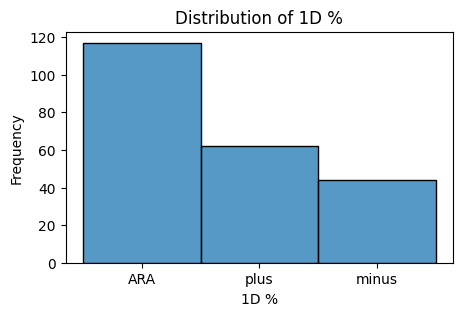

In [344]:
plt.figure(figsize=(5, 3))
sns.histplot(df['1D %'])
plt.title('Distribution of 1D %')
plt.xlabel('1D %')
plt.ylabel('Frequency')
plt.show()

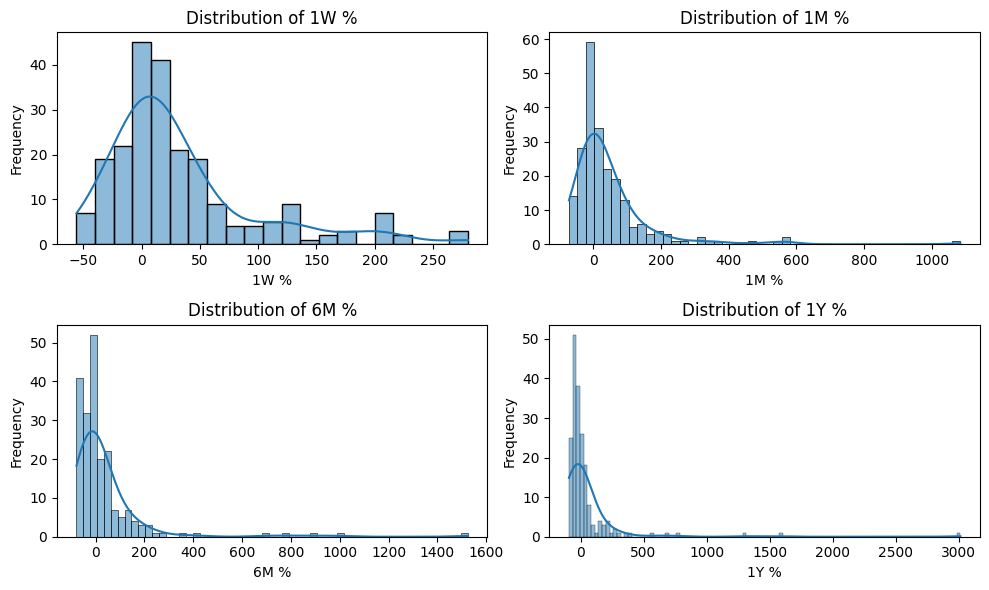

In [345]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
cols = ['1W %', '1M %', '6M %', '1Y %']
titles = ['Distribution of 1W %', 'Distribution of 1M %', 'Distribution of 6M %', 'Distribution of 1Y %']

for ax, col, title in zip(axes.flat, cols, titles):
    sns.histplot(df[col].dropna(), ax=ax, kde=True)
    ax.set_title(title)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [346]:
df[['1D %', '1W %', '1M %', '6M %', '1Y %']].describe()

,1W %,1M %,6M %,1Y %
count,223.000000,221.000000,205.000000,193.000000
mean,33.600897,46.339367,36.365854,43.761658
std,65.820582,123.192266,174.078999,285.472553
min,-56.000000,-72.000000,-78.000000,-92.000000
25%,-4.000000,-11.000000,-41.000000,-50.000000
50%,13.000000,10.000000,-7.000000,-22.000000
75%,46.500000,66.000000,42.000000,35.000000
max,280.000000,1085.000000,1525.000000,3014.000000


In [347]:
def categorize_mid(val):
    if pd.isnull(val):
        return val
    return 'good' if val >= 5 else 'bad'

def categorize_long(val):
    if pd.isnull(val):
        return val
    elif val >= 0:
        return 'plus'
    else:
        return 'minus'
    
for col in ['1W %', '1M %']:
    df[col] = df[col].apply(categorize_mid)
for col in ['6M %', '1Y %']:
    df[col] = df[col].apply(categorize_long)

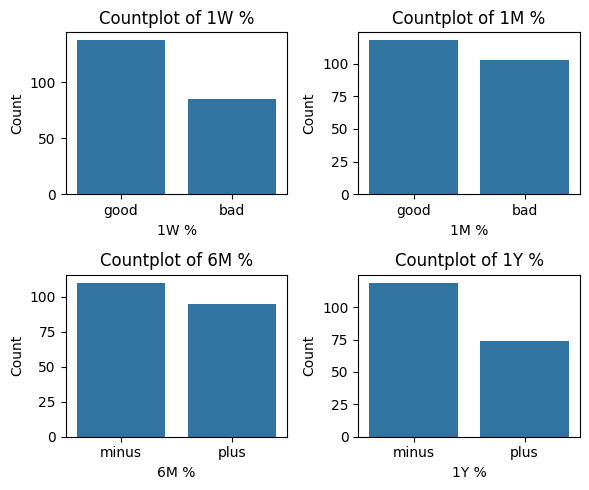

In [348]:
plt.figure(figsize=(6, 5))
for i, col in enumerate(['1W %', '1M %', '6M %', '1Y %'], 1):
    plt.subplot(2, 2, i)
    sns.countplot(x=df[col])
    plt.title(f'Countplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
plt.tight_layout()
plt.show()

#### Underwriter

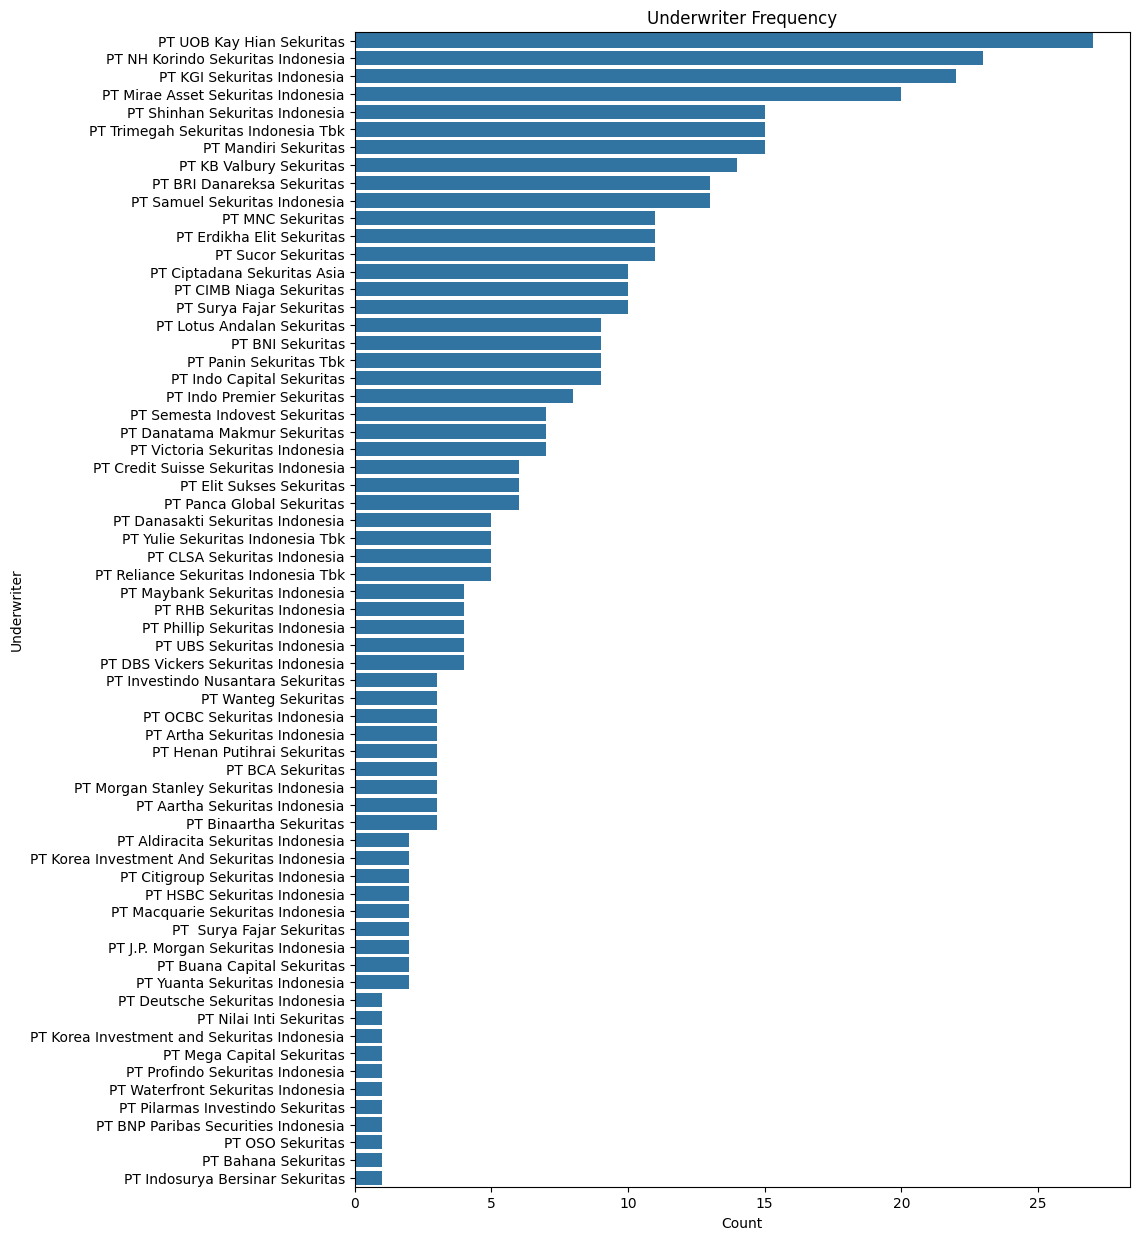

In [349]:
underwriters_exploded = df['Underwriter'].str.split(';').explode().str.strip()
plt.figure(figsize=(10, 15))
sns.countplot(y=underwriters_exploded, order=underwriters_exploded.value_counts().index)
plt.ylabel('Underwriter')
plt.xlabel('Count')
plt.title('Underwriter Frequency')
plt.show()


In [350]:
freq_dict = {}
aset_dict = {}
jumlah_dict = {}

for idx, row in df.iterrows():
    underwriters = [uw.strip() for uw in row['Underwriter'].split(';') if uw.strip()]
    persen = row['Persen Saham Ditawarkan']
    listed_share = row['Listed Share']
    harga_final = row['Harga Final']
    total_aset = row['Total Aset']
    
    jumlah = listed_share * harga_final * persen
    for uw in underwriters:
        freq_dict[uw] = freq_dict.get(uw, 0) + 1
        aset_dict[uw] = aset_dict.get(uw, 0.0) + total_aset
        jumlah_dict[uw] = jumlah_dict.get(uw, 0.0) + jumlah

uw_stats = []
for uw in freq_dict:
    freq = freq_dict[uw]
    avg_aset = aset_dict[uw] / freq if freq else 0
    avg_jumlah = jumlah_dict[uw] / freq if freq else 0
    uw_stats.append((uw, freq, avg_aset, avg_jumlah))

uw_df = pd.DataFrame(uw_stats, columns=['underwriter', 'freq', 'avg_aset', 'avg_jumlah']).reset_index(drop=True)
uw_df.head()

,underwriter,freq,avg_aset,avg_jumlah
0,PT Surya Fajar Sekuritas,10,1.715198e+11,1.040427e+11
1,PT UOB Kay Hian Sekuritas,27,1.987166e+12,6.286920e+11
2,PT KGI Sekuritas Indonesia,22,2.307070e+11,9.244884e+10
3,PT Panca Global Sekuritas,6,6.017120e+12,1.733810e+11
4,PT Yuanta Sekuritas Indonesia,2,1.259180e+12,2.125180e+11


In [351]:
high_aset = uw_df['avg_aset'].quantile(0.75)
low_aset = uw_df['avg_aset'].quantile(0.25)

def aset_category(val):
    if val >= high_aset:
        return 'high'
    elif val <= low_aset:
        return 'low'
    else:
        return 'mid'

uw_df['avg_aset_category'] = uw_df['avg_aset'].apply(aset_category)

high_freq = uw_df['freq'].quantile(0.75)
low_freq = uw_df['freq'].quantile(0.25)

def freq_category(val):
    if val >= high_freq:
        return 'high'
    elif val <= low_freq:
        return 'low'
    else:
        return 'mid'

uw_df['freq_category'] = uw_df['freq'].apply(freq_category)
uw_df.head()

,underwriter,freq,avg_aset,avg_jumlah,avg_aset_category,freq_category
0,PT Surya Fajar Sekuritas,10,1.715198e+11,1.040427e+11,low,high
1,PT UOB Kay Hian Sekuritas,27,1.987166e+12,6.286920e+11,mid,high
2,PT KGI Sekuritas Indonesia,22,2.307070e+11,9.244884e+10,low,high
3,PT Panca Global Sekuritas,6,6.017120e+12,1.733810e+11,mid,mid
4,PT Yuanta Sekuritas Indonesia,2,1.259180e+12,2.125180e+11,mid,low


In [352]:
#uw_df.to_csv('uw_df.csv', index=False)

In [353]:
df['lead_underwriter'] = df['Underwriter'].str.split(';').str[0].str.strip()
df = df.drop(columns=['Underwriter'])

In [354]:
uw_map_freq_cat = uw_df.set_index('underwriter')['freq_category'].to_dict()
uw_map_aset_cat = uw_df.set_index('underwriter')['avg_aset_category'].to_dict()

df['underwriter_freq_category'] = df['lead_underwriter'].map(uw_map_freq_cat)
df['underwriter_avg_aset_category'] = df['lead_underwriter'].map(uw_map_aset_cat)

In [355]:
cols = list(df.columns)
last3 = cols[-3:]

idx = cols.index('Nama Perusahaan')
for col in last3:
    cols.remove(col)
for i, col in enumerate(last3):
    cols.insert(idx + 1 + i, col)

df = df[cols]

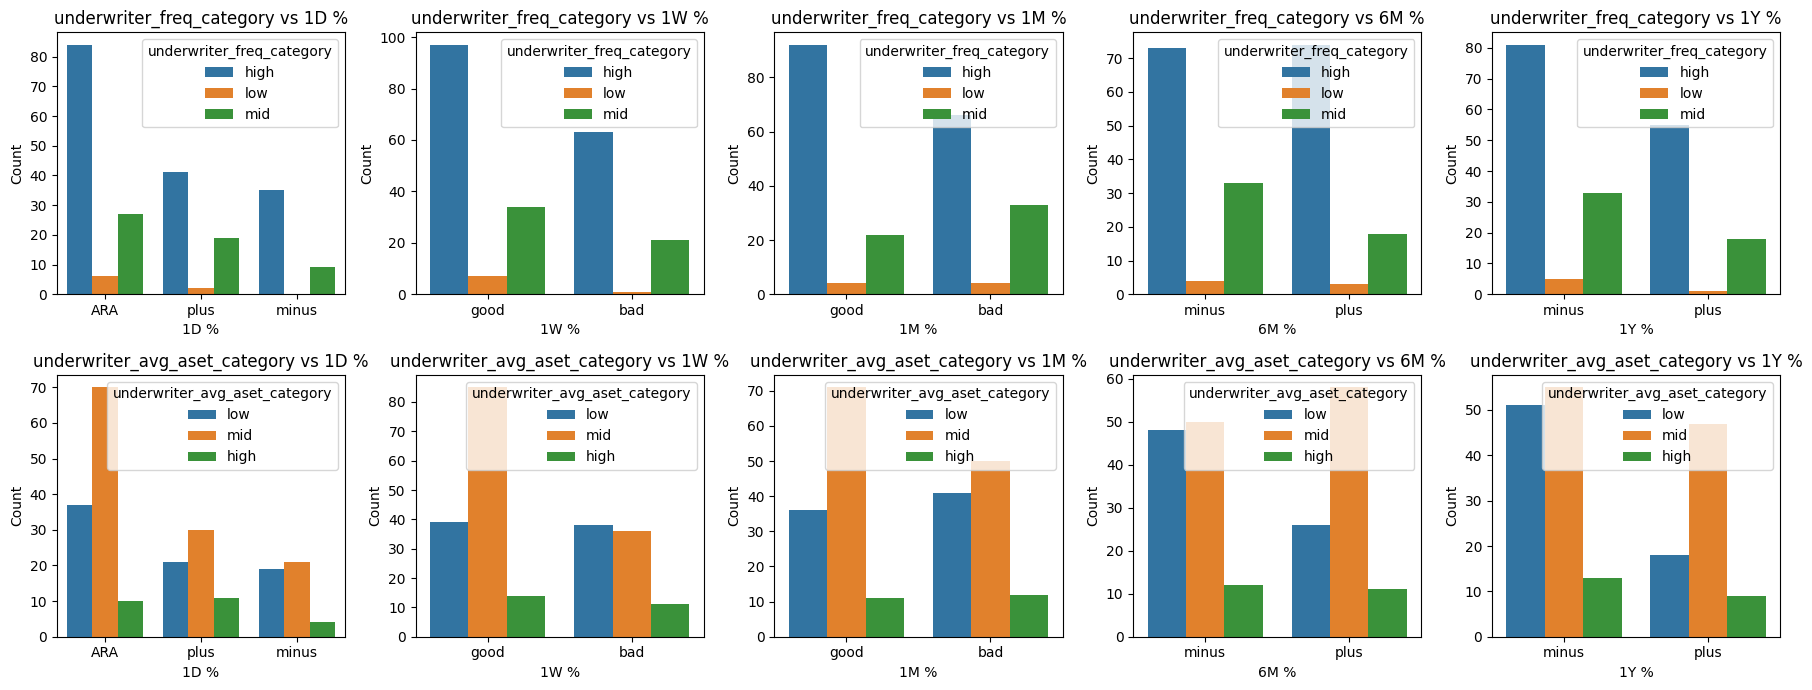

In [356]:
fig, axes = plt.subplots(2, 5, figsize=(18, 7))
target_cols = ['1D %', '1W %', '1M %', '6M %', '1Y %']
plot_cols = ['underwriter_freq_category', 'underwriter_avg_aset_category']

for i, col in enumerate(plot_cols):
    for j, target in enumerate(target_cols):
        ax = axes[i, j]
        sns.countplot(x=df[target], hue=df[col], ax=ax)
        ax.set_title(f"{col} vs {target}")
        ax.set_xlabel(target)
        ax.set_ylabel('Count')
        ax.legend(title=col, loc='best')

plt.tight_layout()
plt.show()

#### VIX

In [357]:
vix_df = pd.read_csv('vix-daily.csv')
vix_df['DATE'] = pd.to_datetime(vix_df['DATE'])
df['Tanggal Listing'] = pd.to_datetime(df['Tanggal Listing'], format='%d-%b-%y', errors='coerce')
vix_df = vix_df.rename(columns={'CLOSE': 'vix'})
df = df.merge(vix_df[['DATE', 'vix']], left_on='Tanggal Listing', right_on='DATE', how='left')
df = df.drop(columns=['DATE'], errors='ignore')
df.head(1)


,Ticker,Nama Perusahaan,lead_underwriter,underwriter_freq_category,underwriter_avg_aset_category,Tanggal Listing,Sektor,Papan Pencatatan,Ownership,Listed Share,...,Pendapatan,Laba Kotor,Laba Berjalan (Bukan Komperhensif),Harga Final,1D %,1W %,1M %,6M %,1Y %,vix
0,UNIQ,PT Ulima Nitra Tbk,PT Surya Fajar Sekuritas,high,low,2021-03-08,Energy,utama,lainnya,3.138983e+09,...,2.709260e+11,2.454700e+10,-5.617000e+09,118.0,ARA,good,good,minus,minus,25.47


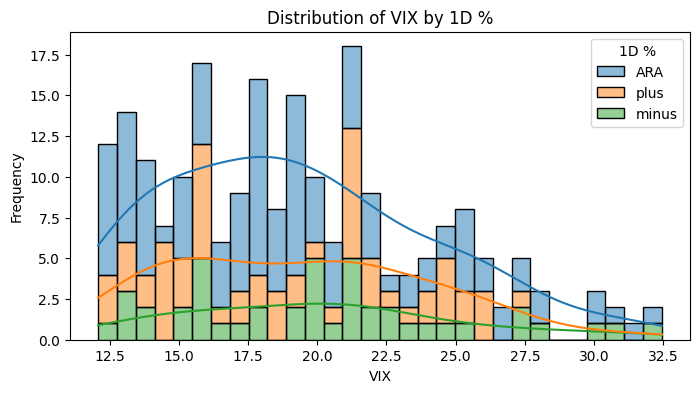

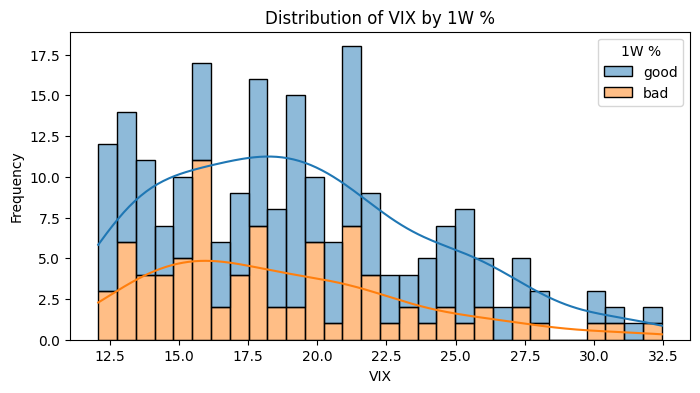

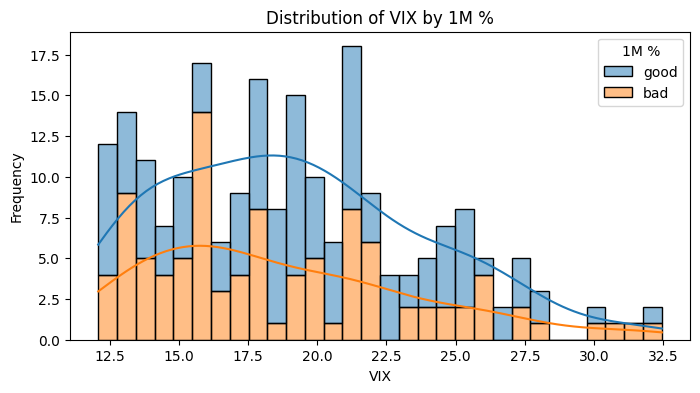

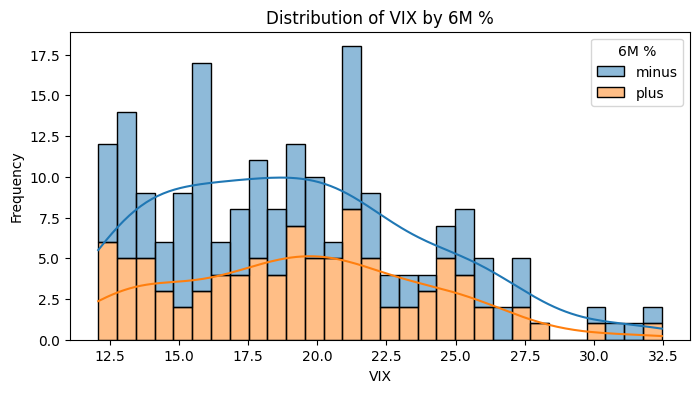

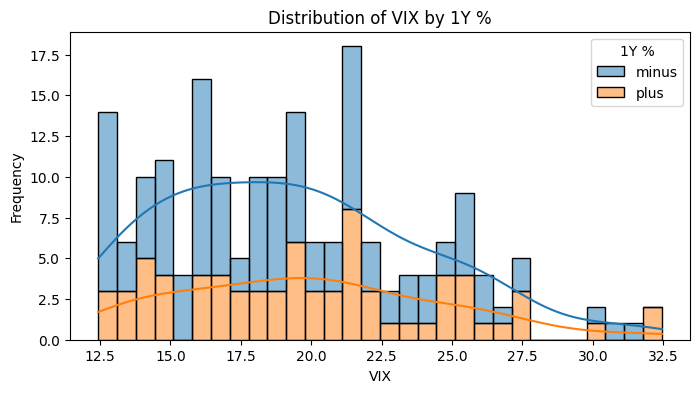

In [358]:
for col in df.columns[-6:-1]:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x='vix', hue=col, bins=30, kde=True, multiple='stack')
    plt.title(f'Distribution of VIX by {col}')
    plt.xlabel('VIX')
    plt.ylabel('Frequency')
    plt.show()

In [359]:
def categorize_vix(val):
    if pd.isnull(val):
        return val
    elif val < 15:
        return 'low'
    elif val < 25:
        return 'mid'
    else:
        return 'high'

df['vix_category'] = df['vix'].apply(categorize_vix)
df['vix_category'].value_counts()

vix_category
mid     142
low      46
high     31
Name: count, dtype: int64

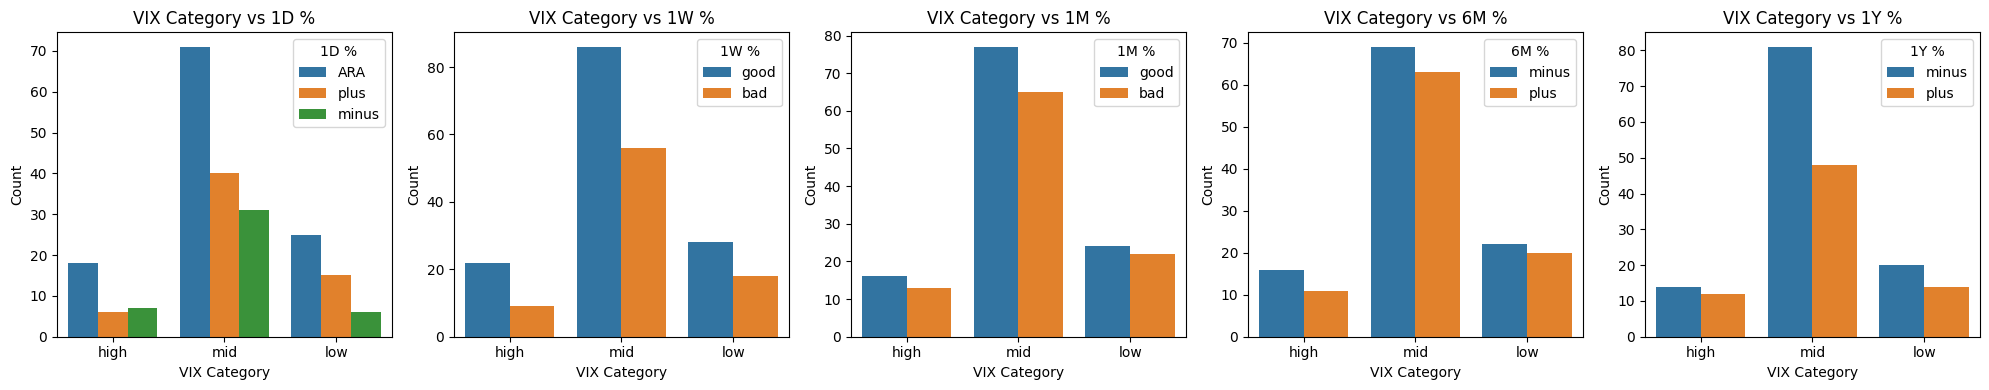

In [360]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['vix_category'], hue=df[col], ax=axes[i])
    axes[i].set_title(f'VIX Category vs {col}')
    axes[i].set_xlabel('VIX Category')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

In [361]:
# sepertinya tidak guna

In [362]:
df = df.drop(columns=['vix', 'vix_category'])

#### Seasonality

In [363]:
def month_to_season(month):
    if month in [12, 1, 2]:
        return 'Rainy'
    elif month in [3, 4, 5]:
        return 'Dry Early'
    elif month in [6, 7, 8]:
        return 'Dry Peak'
    elif month in [9, 10, 11]:
        return 'Dry Late'
    else:
        return 'Unknown'

df['Listing Month'] = df['Tanggal Listing'].dt.month
df['Listing Season'] = df['Listing Month'].apply(month_to_season)
df = df.drop(columns=['Listing Month', 'Tanggal Listing'])
df['Listing Season'].value_counts()


Listing Season
Rainy        74
Dry Peak     60
Dry Late     45
Dry Early    44
Name: count, dtype: int64

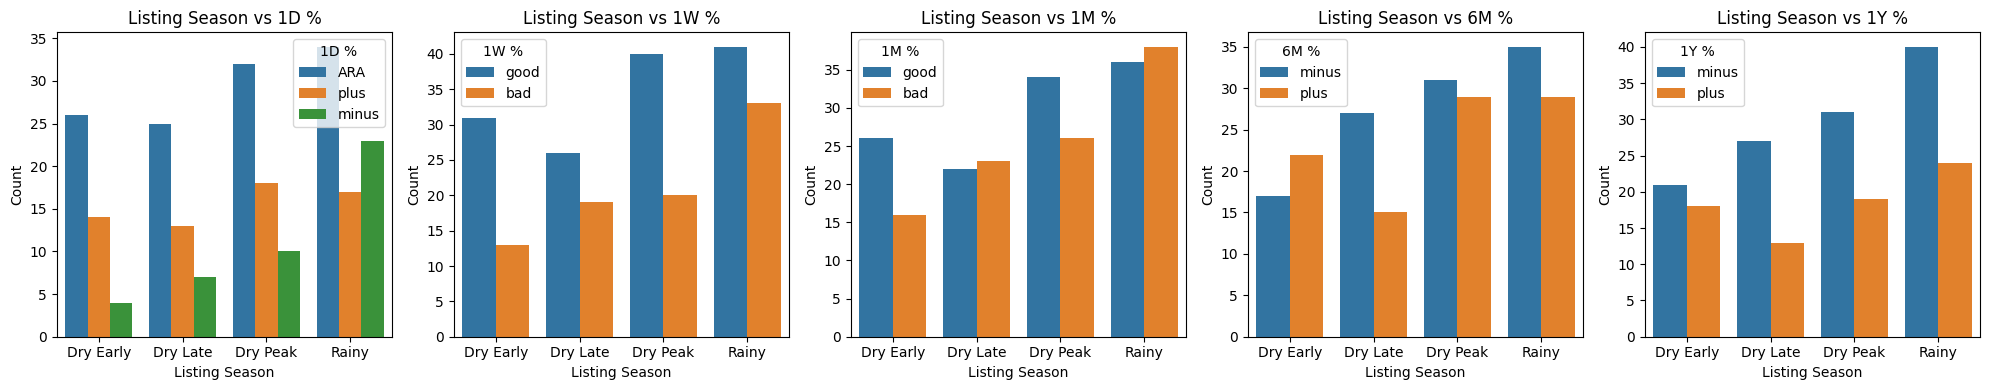

In [364]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, col in enumerate(['1D %', '1W %', '1M %', '6M %', '1Y %']):
    sns.countplot(x=df['Listing Season'], hue=df[col], ax=axes[i])
    axes[i].set_title(f'Listing Season vs {col}')
    axes[i].set_xlabel('Listing Season')
    axes[i].set_ylabel('Count')
    axes[i].legend(title=col, loc='best')
plt.tight_layout()
plt.show()

#### Financials

In [365]:
df['ipo_raised_fund'] = df['Listed Share'] * df['Harga Final'] * df['Persen Saham Ditawarkan']

df['equity'] = df['Total Aset'] - df['Total Liabilitas']
df['leverage'] = df['Total Liabilitas'] / df['equity']
df['turnover'] = df['Pendapatan'] / df['Total Aset']


df['PER'] = df['Harga Final'] / (df['Laba Berjalan (Bukan Komperhensif)'] / df['Listed Share'])
df['PBV'] = df['Harga Final'] / (df['equity'] / df['Listed Share'])
df['PER'] = df['PER'].clip(upper=100)
df['PBV'] = df['PBV'].clip(upper=10)

df['ROA'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['Total Aset']
df['ROE'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['equity']
df['NPM'] = df['Laba Berjalan (Bukan Komperhensif)'] / df['Pendapatan']

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 33 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Ticker                              223 non-null    object 
 1   Nama Perusahaan                     223 non-null    object 
 2   lead_underwriter                    223 non-null    object 
 3   underwriter_freq_category           223 non-null    object 
 4   underwriter_avg_aset_category       223 non-null    object 
 5   Sektor                              223 non-null    object 
 6   Papan Pencatatan                    223 non-null    object 
 7   Ownership                           223 non-null    object 
 8   Listed Share                        223 non-null    float64
 9   Persen Saham Ditawarkan             223 non-null    float64
 10  Rencana Penggunaan Dana IPO         223 non-null    object 
 11  Valuation Currency                  223 non-n

In [366]:
df = df.drop(df.columns[[8, 10, 11, 13, 15, 16]], axis=1)

In [367]:
cols = list(df.columns)
cols_to_move = cols[11:17]
cols_new = [col for col in cols if col not in cols_to_move] + cols_to_move
df = df[cols_new]

In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223 entries, 0 to 222
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Ticker                         223 non-null    object 
 1   Nama Perusahaan                223 non-null    object 
 2   lead_underwriter               223 non-null    object 
 3   underwriter_freq_category      223 non-null    object 
 4   underwriter_avg_aset_category  223 non-null    object 
 5   Sektor                         223 non-null    object 
 6   Papan Pencatatan               223 non-null    object 
 7   Ownership                      223 non-null    object 
 8   Persen Saham Ditawarkan        223 non-null    float64
 9   Total Aset                     223 non-null    float64
 10  Pendapatan                     223 non-null    float64
 11  Listing Season                 223 non-null    object 
 12  ipo_raised_fund                223 non-null    flo

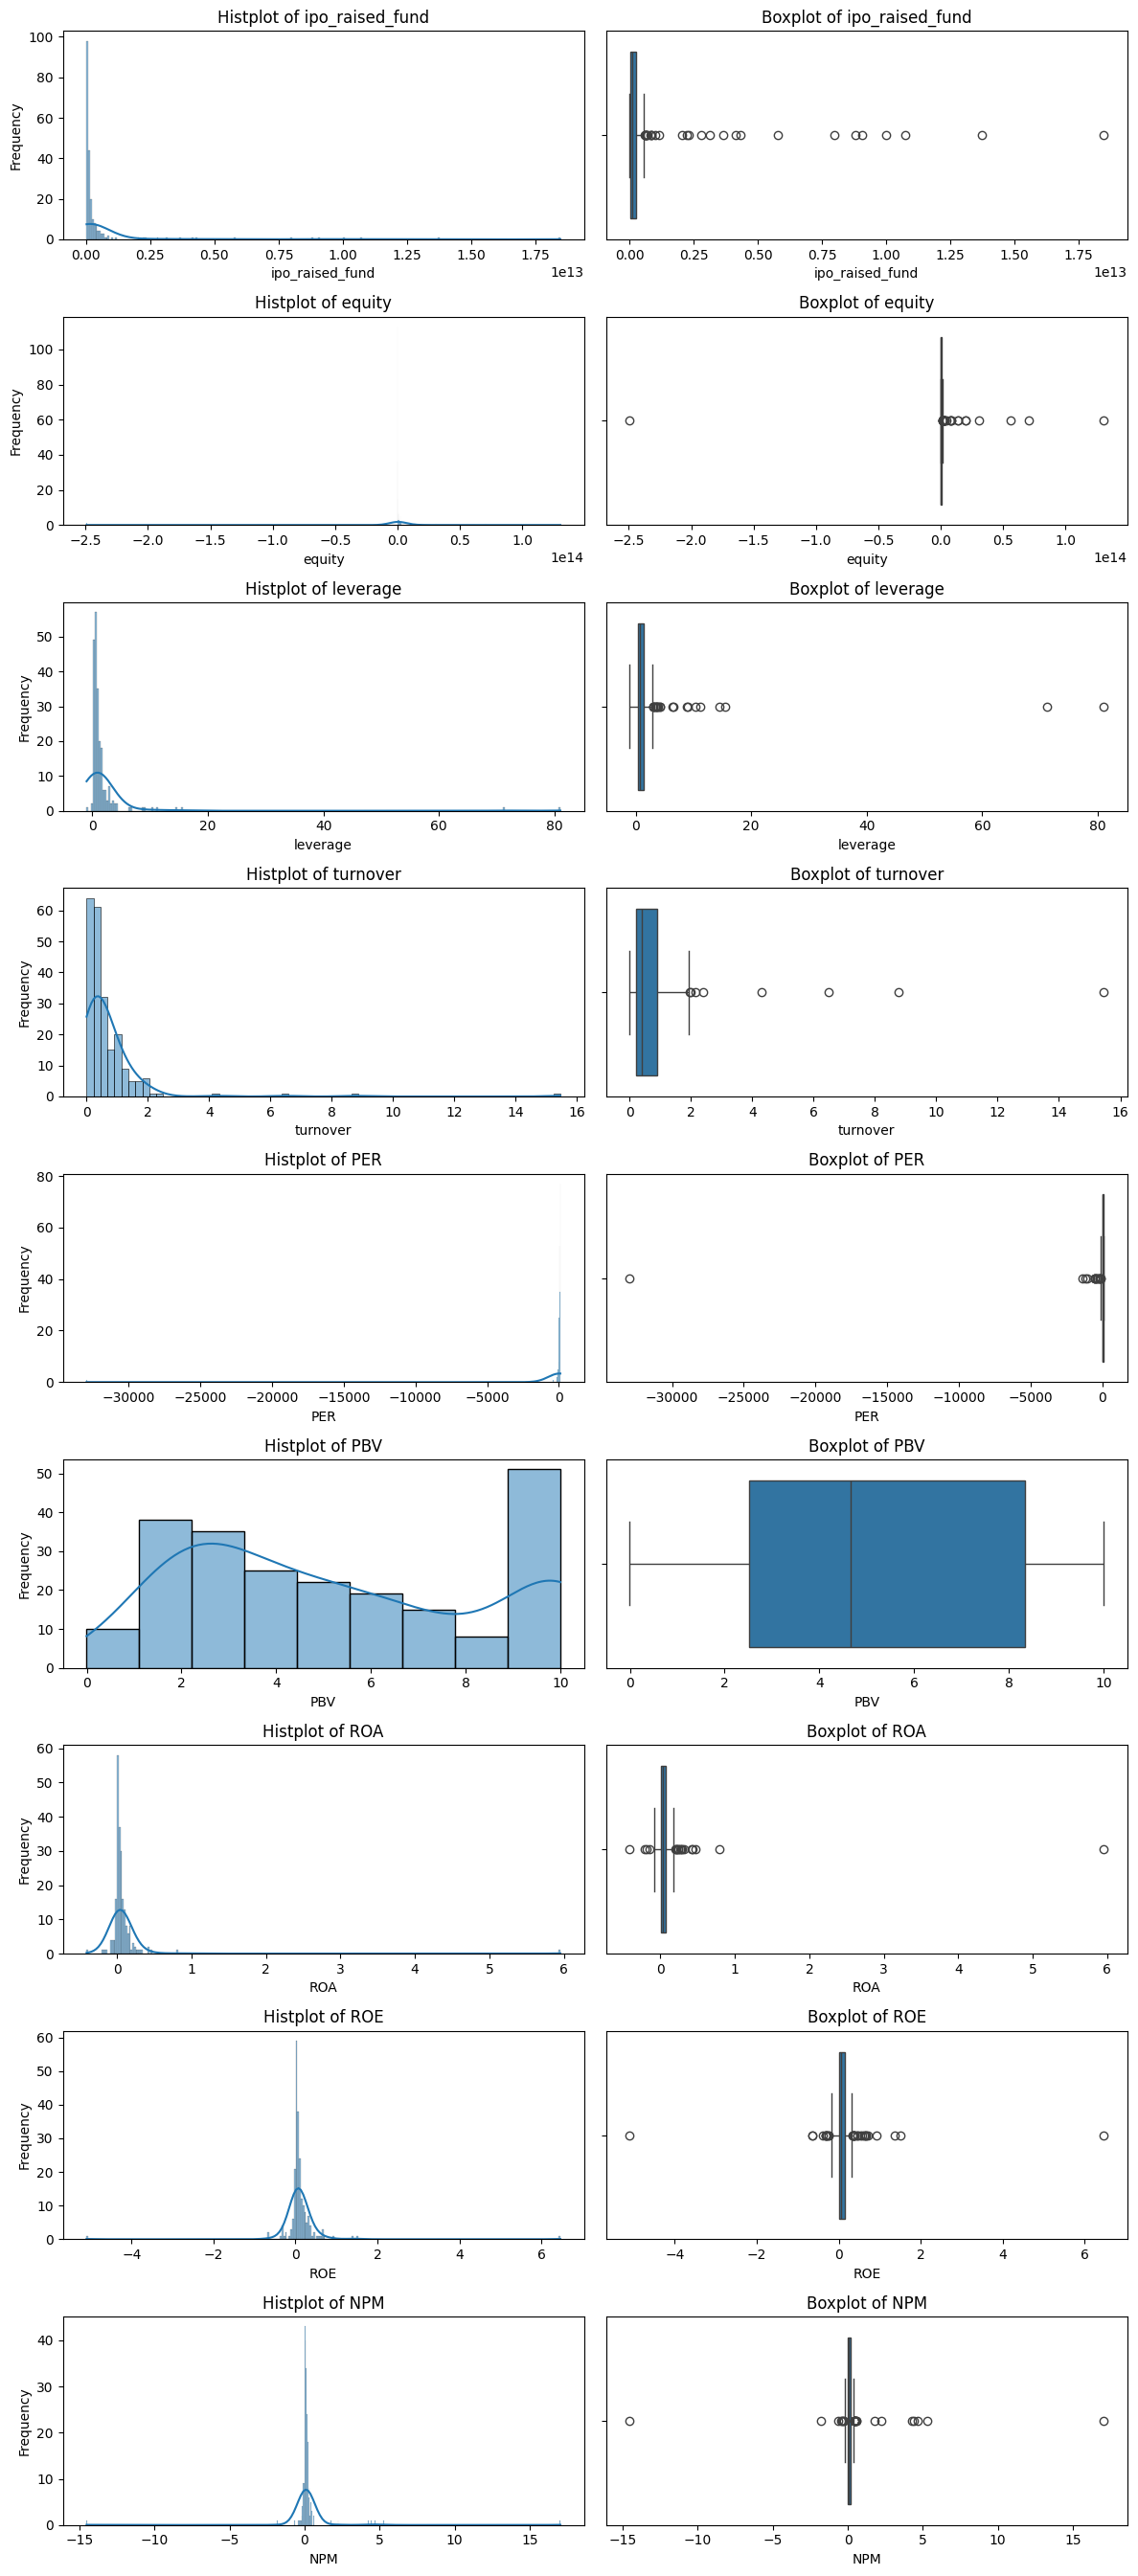

In [369]:
cols_to_plot = df.columns[12:21]
fig, axes = plt.subplots(len(cols_to_plot), 2, figsize=(12, 3 * len(cols_to_plot)))

for idx, col in enumerate(cols_to_plot):
    sns.histplot(df[col].dropna(), ax=axes[idx, 0], kde=True)
    axes[idx, 0].set_title(f'Histplot of {col}')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')
    
    sns.boxplot(x=df[col].dropna(), ax=axes[idx, 1], orient='h')
    axes[idx, 1].set_title(f'Boxplot of {col}')
    axes[idx, 1].set_xlabel(col)

plt.tight_layout()
plt.show()

In [370]:
cols_to_log = [col for col in df.columns[12:21] if col != 'PBV']

for col in cols_to_log:
    df[col] = np.log1p(df[col].clip(lower=1e-9))

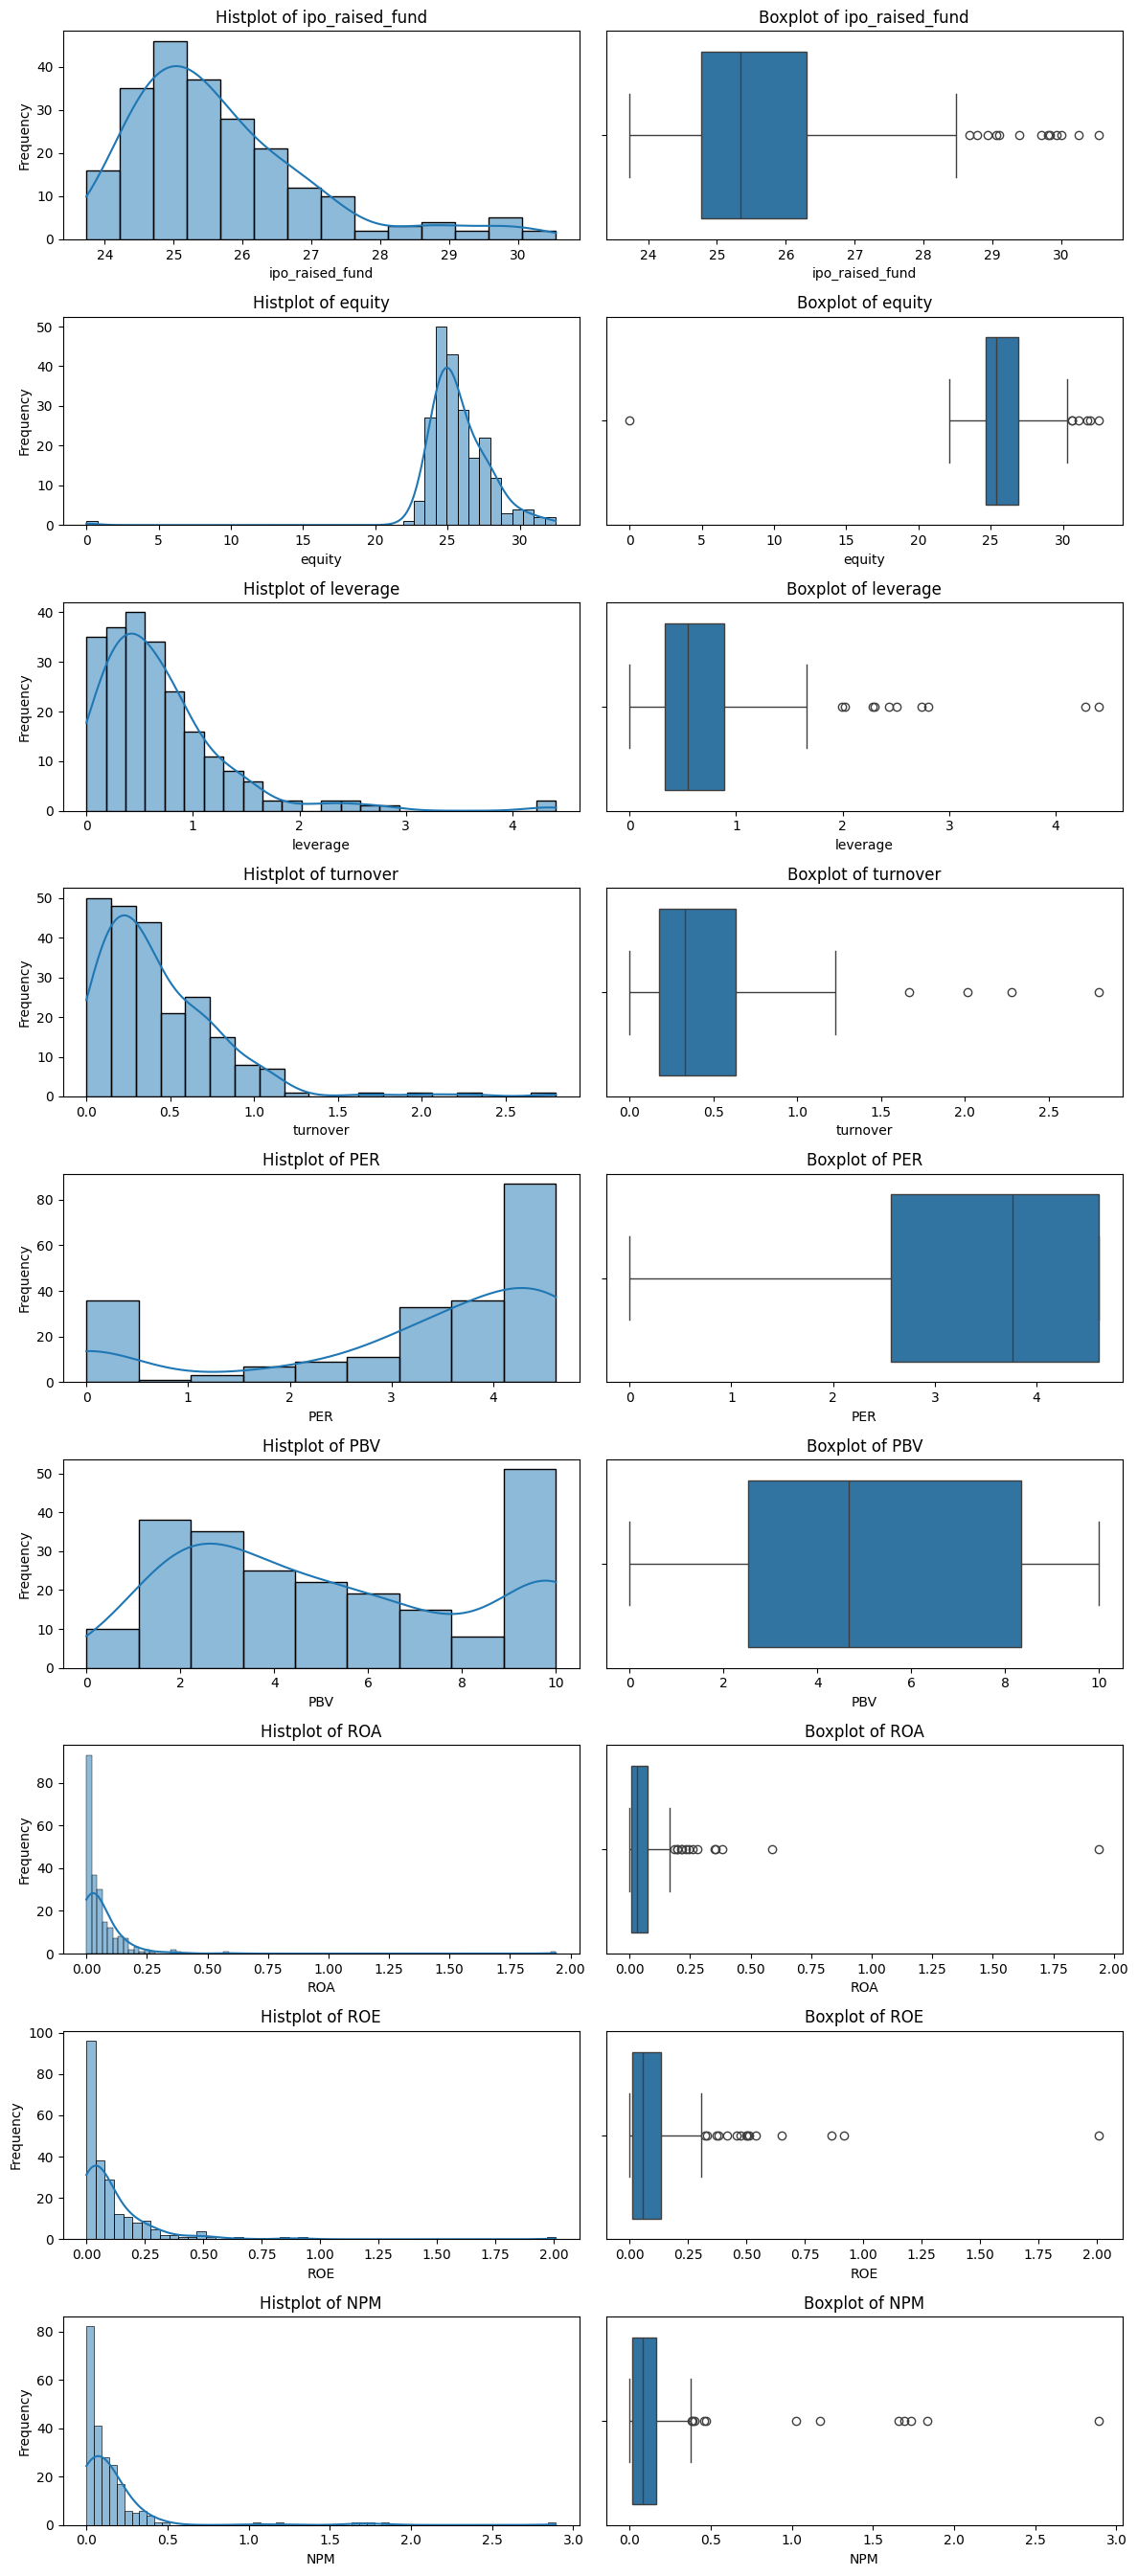

In [371]:
cols_to_plot = df.columns[12:21]
fig, axes = plt.subplots(len(cols_to_plot), 2, figsize=(12, 3 * len(cols_to_plot)))

for idx, col in enumerate(cols_to_plot):
    sns.histplot(df[col].dropna(), ax=axes[idx, 0], kde=True)
    axes[idx, 0].set_title(f'Histplot of {col}')
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].set_ylabel('Frequency')
    
    sns.boxplot(x=df[col].dropna(), ax=axes[idx, 1], orient='h')
    axes[idx, 1].set_title(f'Boxplot of {col}')
    axes[idx, 1].set_xlabel(col)

plt.tight_layout()
plt.show()

### Encoding

In [372]:
df = df.drop('Ticker', axis = 1)

In [373]:
df = df.drop('Nama Perusahaan', axis = 1)

In [374]:
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    if col != 'Underwriter':
        print(f"{col}:")
        print(df[col].unique())
        print('-' * 40)

lead_underwriter:
['PT Surya Fajar Sekuritas' 'PT UOB Kay Hian Sekuritas'
 'PT KGI Sekuritas Indonesia' 'PT  Surya Fajar Sekuritas'
 'PT MNC Sekuritas' 'PT Mirae Asset Sekuritas Indonesia'
 'PT Trimegah Sekuritas Indonesia Tbk' 'PT Investindo Nusantara Sekuritas'
 'PT BNI Sekuritas' 'PT Panin Sekuritas Tbk'
 'PT Artha Sekuritas Indonesia' 'PT NH Korindo Sekuritas Indonesia'
 'PT Aartha Sekuritas Indonesia' 'PT Ciptadana Sekuritas Asia'
 'PT Semesta Indovest Sekuritas' 'PT Danatama Makmur Sekuritas'
 'PT Samuel Sekuritas Indonesia' 'PT Victoria Sekuritas Indonesia'
 'PT Shinhan Sekuritas Indonesia' 'PT Lotus Andalan Sekuritas'
 'PT KB Valbury Sekuritas' 'PT Reliance Sekuritas Indonesia Tbk'
 'PT BRI Danareksa Sekuritas' 'PT Wanteg Sekuritas'
 'PT RHB Sekuritas Indonesia' 'PT Mandiri Sekuritas' 'PT OSO Sekuritas'
 'PT Buana Capital Sekuritas' 'PT BCA Sekuritas' 'PT CIMB Niaga Sekuritas'
 'PT Henan Putihrai Sekuritas' 'PT Sucor Sekuritas'
 'PT Pilarmas Investindo Sekuritas' 'PT CLSA Sekur

In [375]:
label_encoders = {}
encoded_mappings = {}
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le
    encoded_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))
for col, mapping in encoded_mappings.items():
    print(f"Encoding for '{col}':")
    print(mapping)
    print('-' * 40)


Encoding for 'lead_underwriter':
{'PT  Surya Fajar Sekuritas': 0, 'PT Aartha Sekuritas Indonesia': 1, 'PT Artha Sekuritas Indonesia': 2, 'PT BCA Sekuritas': 3, 'PT BNI Sekuritas': 4, 'PT BNP Paribas Securities Indonesia': 5, 'PT BRI Danareksa Sekuritas': 6, 'PT Binaartha Sekuritas': 7, 'PT Buana Capital Sekuritas': 8, 'PT CIMB Niaga Sekuritas': 9, 'PT CLSA Sekuritas Indonesia': 10, 'PT Ciptadana Sekuritas Asia': 11, 'PT Danatama Makmur Sekuritas': 12, 'PT Elit Sukses Sekuritas': 13, 'PT Erdikha Elit Sekuritas': 14, 'PT Henan Putihrai Sekuritas': 15, 'PT Indo Capital Sekuritas': 16, 'PT Indo Premier Sekuritas': 17, 'PT Investindo Nusantara Sekuritas': 18, 'PT KB Valbury Sekuritas': 19, 'PT KGI Sekuritas Indonesia': 20, 'PT Korea Investment And Sekuritas Indonesia': 21, 'PT Lotus Andalan Sekuritas': 22, 'PT MNC Sekuritas': 23, 'PT Mandiri Sekuritas': 24, 'PT Mirae Asset Sekuritas Indonesia': 25, 'PT NH Korindo Sekuritas Indonesia': 26, 'PT OCBC Sekuritas Indonesia': 27, 'PT OSO Sekuritas

### Training

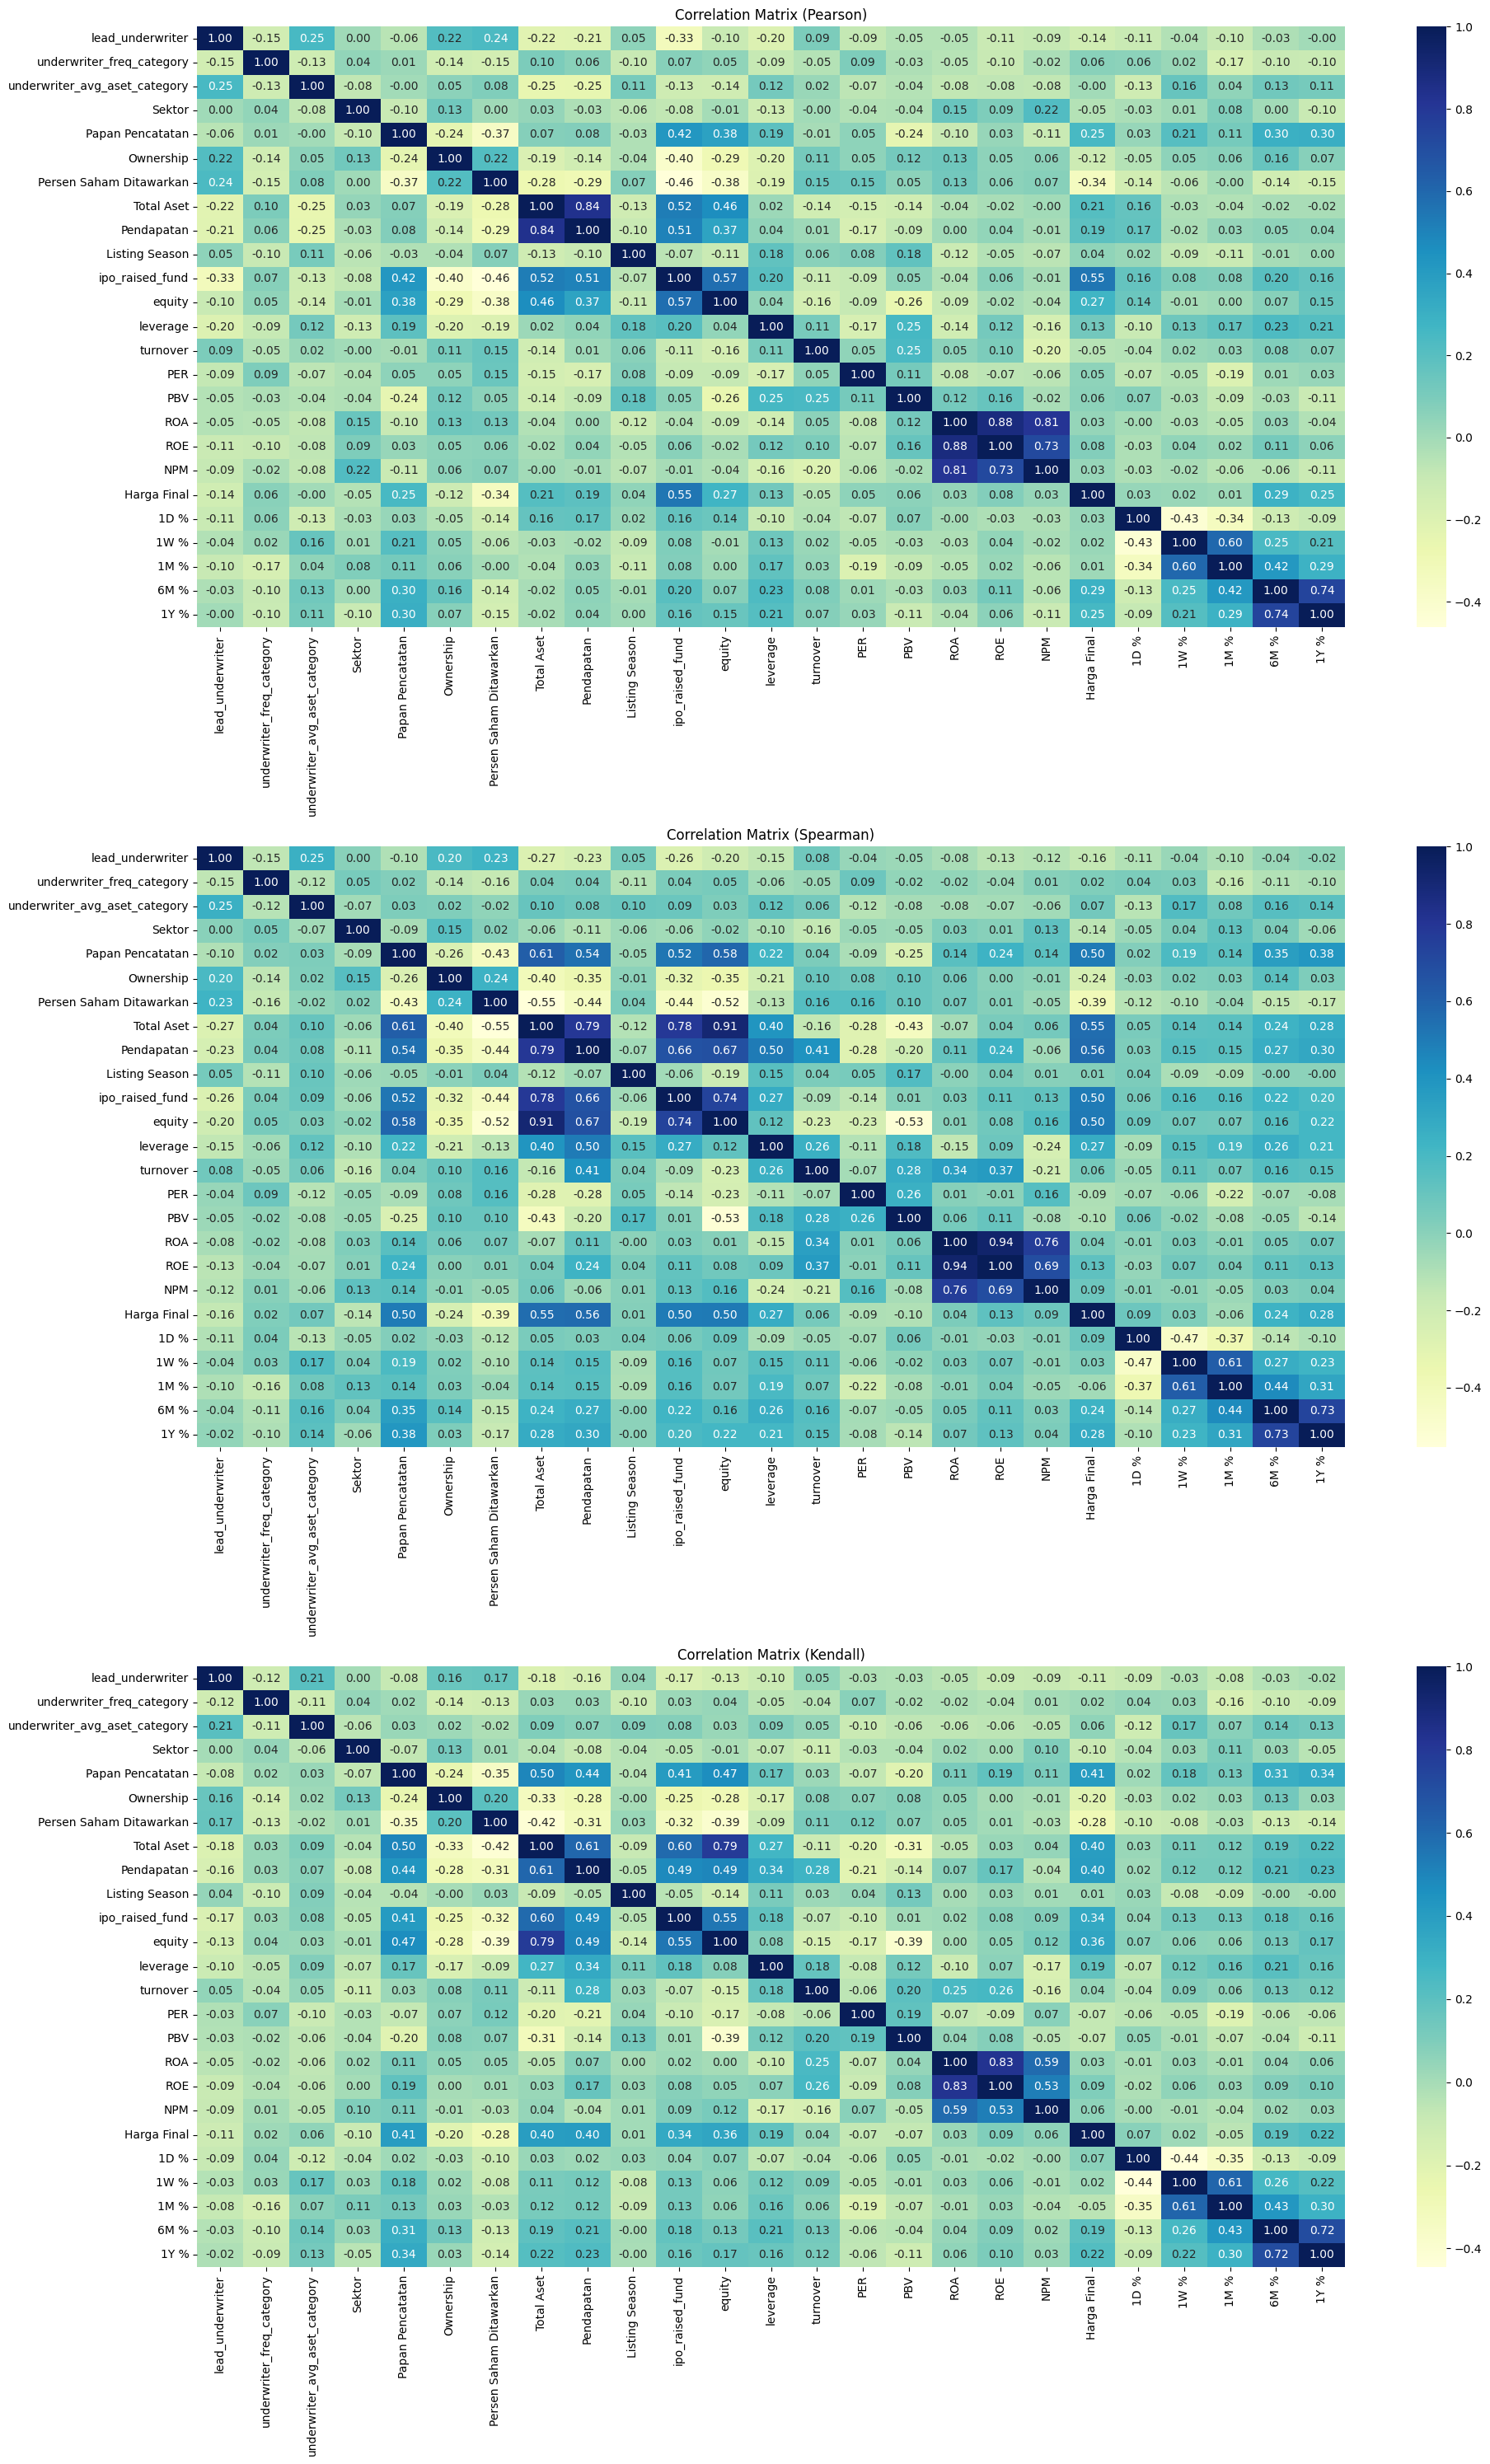

In [376]:
corr_methods = ['pearson', 'spearman', 'kendall']
plt.figure(figsize=(20, 10 * len(corr_methods)))

for i, method in enumerate(corr_methods, 1):
    plt.subplot(len(corr_methods), 1, i)
    corr = df.corr(method=method)
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='YlGnBu', cbar=True)
    plt.title(f'Correlation Matrix ({method.title()})')

plt.tight_layout()
plt.show()


In [405]:
feature_columns =['underwriter_freq_category', 'underwriter_avg_aset_category', 'Papan Pencatatan', 'Ownership', 'Persen Saham Ditawarkan', 'Pendapatan', 'ipo_raised_fund', 'equity', 'leverage', 'turnover', 'PER', 'NPM']
target_columns = ['1D %', '1W %', '1M %', '6M %', '1Y %']

X = df[feature_columns]
y = df[target_columns]

In [406]:
X_1d, X_1w, X_1m, X_6m, X_1y = [X.copy() for _ in range(5)]
y_1d = y['1D %'].copy()
y_1w = y['1W %'].copy()
y_1m = y['1M %'].copy()
y_6m = y['6M %'].copy()
y_1y = y['1Y %'].copy()

In [ ]:
# kecuali 1 D, value '2' berarti null valuenya

mask = (y_1m != 2) & (y_6m != 2) & (y_1y != 2)
X_1m_clean = X_1m[mask]
y_1m_clean = y_1m[mask]
X_6m_clean = X_6m[mask]
y_6m_clean = y_6m[mask]
X_1y_clean = X_1y[mask]
y_1y_clean = y_1y[mask]

In [411]:
X_1d_train, X_1d_test, y_1d_train, y_1d_test = train_test_split(X_1d, y_1d, test_size=0.224, random_state=42, stratify=y_1d)
X_1w_train, X_1w_test, y_1w_train, y_1w_test = train_test_split(X_1w, y_1w, test_size=0.224, random_state=42, stratify=y_1w)
X_1m_train, X_1m_test, y_1m_train, y_1m_test = train_test_split(X_1m_clean, y_1m_clean, test_size=0.224, random_state=42, stratify=y_1m_clean)
X_6m_train, X_6m_test, y_6m_train, y_6m_test = train_test_split(X_6m_clean, y_6m_clean, test_size=0.224, random_state=42, stratify=y_6m_clean)
X_1y_train, X_1y_test, y_1y_train, y_1y_test = train_test_split(X_1y_clean, y_1y_clean, test_size=0.224, random_state=42, stratify=y_1y_clean)

In [428]:
smote = SMOTE(random_state=42)

X_1d_train_sm, y_1d_train_sm = smote.fit_resample(X_1d_train, y_1d_train)
X_1w_train_sm, y_1w_train_sm = smote.fit_resample(X_1w_train, y_1w_train)
X_1m_train_sm, y_1m_train_sm = smote.fit_resample(X_1m_train, y_1m_train)
X_6m_train_sm, y_6m_train_sm = smote.fit_resample(X_6m_train, y_6m_train)
X_1y_train_sm, y_1y_train_sm = smote.fit_resample(X_1y_train, y_1y_train)

print("After SMOTE, 1D % class distribution:", np.bincount(y_1d_train_sm))
print("After SMOTE, 1W % class distribution:", np.bincount(y_1w_train_sm))
print("After SMOTE, 1M % class distribution:", np.bincount(y_1m_train_sm))
print("After SMOTE, 6M % class distribution:", np.bincount(y_6m_train_sm))
print("After SMOTE, 1Y % class distribution:", np.bincount(y_1y_train_sm))

After SMOTE, 1D % class distribution: [91 91 91]
After SMOTE, 1W % class distribution: [107 107]
After SMOTE, 1M % class distribution: [79 79]
After SMOTE, 6M % class distribution: [82 82]
After SMOTE, 1Y % class distribution: [92 92]


c:\Users\nathan\anaconda3\envs\AI\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\nathan\anaconda3\envs\AI\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\nathan\anaconda3\envs\AI\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\nathan\anaconda3\envs\AI\lib\site-packages\skl

#### Random Forest

In [431]:
rf_1d = RandomForestClassifier(random_state=42)
rf_1d.fit(X_1d_train_sm, y_1d_train_sm)

rf_1w = RandomForestClassifier(random_state=42)
rf_1w.fit(X_1w_train_sm, y_1w_train_sm)

rf_1m = RandomForestClassifier(random_state=42)
rf_1m.fit(X_1m_train_sm, y_1m_train_sm)

rf_6m = RandomForestClassifier(random_state=42)
rf_6m.fit(X_6m_train_sm, y_6m_train_sm)

rf_1y = RandomForestClassifier(random_state=42)
rf_1y.fit(X_1y_train_sm, y_1y_train_sm)

RandomForestClassifier(random_state=42)

Results for 1D %:
Accuracy: 0.5000
F1 Score: 0.4839


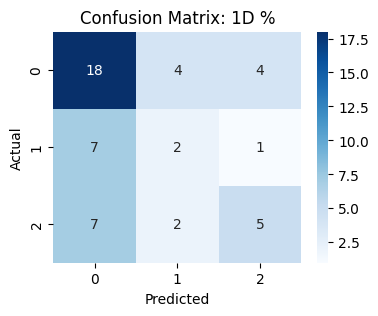

----------------------------------------
Results for 1W %:
Accuracy: 0.5600
F1 Score: 0.5600


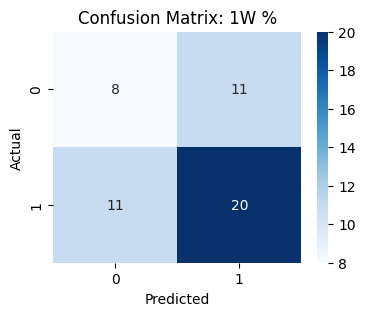

----------------------------------------
Results for 1M %:
Accuracy: 0.6364
F1 Score: 0.6318


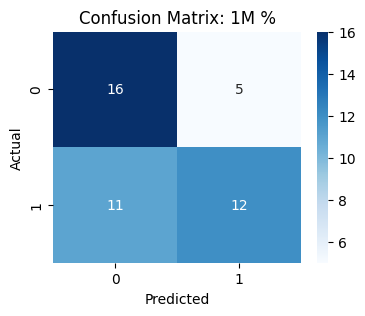

----------------------------------------
Results for 6M %:
Accuracy: 0.6818
F1 Score: 0.6764


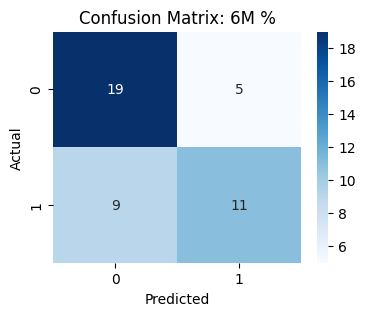

----------------------------------------
Results for 1Y %:
Accuracy: 0.7727
F1 Score: 0.7654


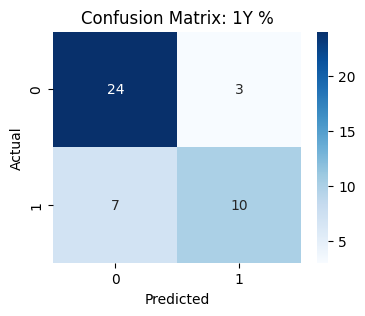

----------------------------------------


In [432]:
for name, y_true, y_pred_ in zip(
    ['1D %', '1W %', '1M %', '6M %', '1Y %'],
    [y_1d_test, y_1w_test, y_1m_test, y_6m_test, y_1y_test],
    [rf_1d.predict(X_1d_test), rf_1w.predict(X_1w_test), rf_1m.predict(X_1m_test), rf_6m.predict(X_6m_test), rf_1y.predict(X_1y_test)]
):
    acc = accuracy_score(y_true, y_pred_)
    f1 = f1_score(y_true, y_pred_, average='weighted')
    cm = confusion_matrix(y_true, y_pred_)
    print(f"Results for {name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print('-' * 40)

#### Catboost + CalibratedSearchCV

CatBoost Results for 1D %:
Accuracy: 0.5400
F1 Score: 0.5175


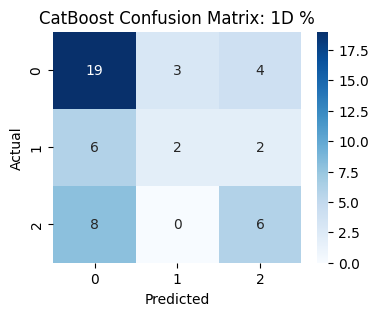

----------------------------------------
CatBoost Results for 1W %:
Accuracy: 0.6400
F1 Score: 0.6297


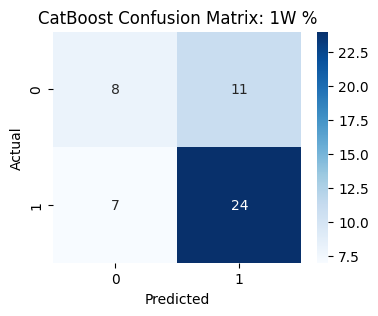

----------------------------------------
CatBoost Results for 1M %:
Accuracy: 0.5682
F1 Score: 0.5603


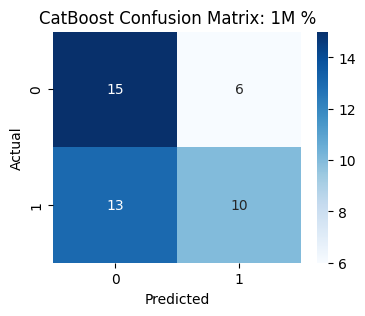

----------------------------------------
CatBoost Results for 6M %:
Accuracy: 0.7045
F1 Score: 0.7038


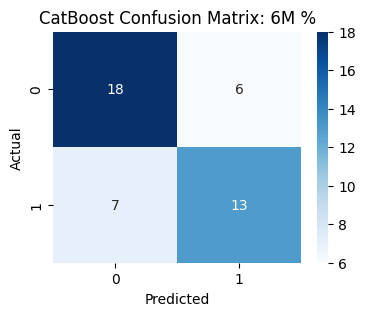

----------------------------------------
CatBoost Results for 1Y %:
Accuracy: 0.7727
F1 Score: 0.7654


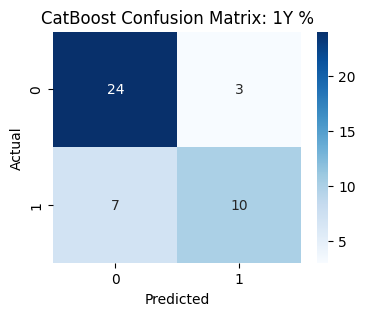

----------------------------------------


In [433]:
param_grid = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.005, 0.01, 0.05, 0.1],
    'iterations': [100, 200, 300]
}

def fit_calibrated_catboost(X_train, y_train):
    base_model = CatBoostClassifier(verbose=0, random_state=42)
    grid = GridSearchCV(base_model, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_model = grid.best_estimator_
    calibrated = CalibratedClassifierCV(best_model, method='sigmoid', cv=3)
    calibrated.fit(X_train, y_train)
    return calibrated

cat_1d = fit_calibrated_catboost(X_1d_train_sm, y_1d_train_sm)
cat_1w = fit_calibrated_catboost(X_1w_train_sm, y_1w_train_sm)
cat_1m = fit_calibrated_catboost(X_1m_train_sm, y_1m_train_sm)
cat_6m = fit_calibrated_catboost(X_6m_train_sm, y_6m_train_sm)
cat_1y = fit_calibrated_catboost(X_1y_train_sm, y_1y_train_sm)

for name, y_true, model, X_test in zip(
    ['1D %', '1W %', '1M %', '6M %', '1Y %'],
    [y_1d_test, y_1w_test, y_1m_test, y_6m_test, y_1y_test],
    [cat_1d, cat_1w, cat_1m, cat_6m, cat_1y],
    [X_1d_test, X_1w_test, X_1m_test, X_6m_test, X_1y_test]
):
    y_pred_ = model.predict(X_test)
    acc = accuracy_score(y_true, y_pred_)
    f1 = f1_score(y_true, y_pred_, average='weighted')
    cm = confusion_matrix(y_true, y_pred_)
    print(f"CatBoost Results for {name}:")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'CatBoost Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print('-' * 40)